# LensPR Benchmark v2: Extended Iterations + Visualization

**Changes from v1:**
- Max iterations: 50 (was 15)
- Added charts and visualizations
- Results saved to `results_v2/`

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import json
import os
from pathlib import Path
from dataclasses import dataclass, field, asdict
from datetime import datetime
from typing import Any

# Load API key from .env
from dotenv import load_dotenv
load_dotenv()

import anthropic
import lenspr

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Initialize
PROJECT_ROOT = Path('..').resolve()
RESULTS_DIR = Path('results_v2')  # New results directory
RESULTS_DIR.mkdir(exist_ok=True)

# Config
MAX_ITERATIONS = 50  # Increased from 15

client = anthropic.Anthropic()
ctx = lenspr.init(str(PROJECT_ROOT))

print(f"Project: {PROJECT_ROOT}")
print(f"Max iterations: {MAX_ITERATIONS}")
print(f"Results dir: {RESULTS_DIR}")

Project: /Users/kyryloprymak/code/lenspr
Max iterations: 50
Results dir: results_v2


## Metrics & Tools

In [2]:
@dataclass
class BenchmarkResult:
    """Stores results from a single benchmark run."""
    task_id: str
    mode: str
    total_input_tokens: int = 0
    total_output_tokens: int = 0
    iterations: int = 0
    tool_calls: list = field(default_factory=list)
    tool_call_count: int = 0
    completed: bool = False
    error: str | None = None
    started_at: str = ""
    finished_at: str = ""
    duration_seconds: float = 0.0
    messages: list = field(default_factory=list)
    
    # Track tokens per iteration for visualization
    tokens_per_iteration: list = field(default_factory=list)
    
    def save(self, path: Path):
        with open(path, 'w') as f:
            json.dump(asdict(self), f, indent=2, default=str)
    
    @classmethod
    def load(cls, path: Path) -> 'BenchmarkResult':
        with open(path) as f:
            data = json.load(f)
        return cls(**data)

In [3]:
# Standard tools (without LensPR)
STANDARD_TOOLS = [
    {
        "name": "read_file",
        "description": "Read a file from the filesystem. Returns the file content.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "Path to the file to read"}
            },
            "required": ["path"]
        }
    },
    {
        "name": "write_file",
        "description": "Write content to a file. Creates or overwrites the file.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "Path to the file"},
                "content": {"type": "string", "description": "Content to write"}
            },
            "required": ["path", "content"]
        }
    },
    {
        "name": "search_files",
        "description": "Search for a pattern in files using grep. Returns matching lines with file paths.",
        "input_schema": {
            "type": "object",
            "properties": {
                "pattern": {"type": "string", "description": "Pattern to search for"},
                "path": {"type": "string", "description": "Directory to search in", "default": "."}
            },
            "required": ["pattern"]
        }
    },
    {
        "name": "list_files",
        "description": "List files in a directory.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "Directory path", "default": "."}
            }
        }
    },
    {
        "name": "run_tests",
        "description": "Run pytest on the project. Returns test output.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "Test path", "default": "tests/"}
            }
        }
    },
    {
        "name": "task_complete",
        "description": "Call this when the task is complete. Provide a summary of what was done.",
        "input_schema": {
            "type": "object",
            "properties": {
                "summary": {"type": "string", "description": "Summary of completed work"}
            },
            "required": ["summary"]
        }
    }
]

LENSPR_TOOLS = lenspr.get_claude_tools() + STANDARD_TOOLS
print(f"Standard tools: {len(STANDARD_TOOLS)}, LensPR tools: {len(LENSPR_TOOLS)}")

Standard tools: 6, LensPR tools: 34


In [4]:
import subprocess

def handle_standard_tool(name: str, inputs: dict) -> str:
    try:
        if name == "read_file":
            path = PROJECT_ROOT / inputs["path"]
            if not path.exists():
                return f"Error: File not found: {inputs['path']}"
            return path.read_text()
        elif name == "write_file":
            path = PROJECT_ROOT / inputs["path"]
            path.parent.mkdir(parents=True, exist_ok=True)
            path.write_text(inputs["content"])
            return f"Successfully wrote {len(inputs['content'])} characters to {inputs['path']}"
        elif name == "search_files":
            search_path = PROJECT_ROOT / inputs.get("path", ".")
            result = subprocess.run(
                ["grep", "-rn", inputs["pattern"], str(search_path)],
                capture_output=True, text=True, timeout=30
            )
            output = result.stdout or "No matches found"
            if len(output) > 10000:
                output = output[:10000] + f"\n... (truncated)"
            return output
        elif name == "list_files":
            path = PROJECT_ROOT / inputs.get("path", ".")
            if not path.exists():
                return f"Error: Directory not found"
            files = [str(p.relative_to(PROJECT_ROOT)) for p in sorted(path.rglob("*.py"))[:100]]
            return "\n".join(files) if files else "No Python files found"
        elif name == "run_tests":
            result = subprocess.run(
                ["python", "-m", "pytest", inputs.get("path", "tests/"), "-v", "--tb=short"],
                capture_output=True, text=True, timeout=120, cwd=str(PROJECT_ROOT)
            )
            output = result.stdout + result.stderr
            return output[:15000] if len(output) > 15000 else output
        elif name == "task_complete":
            return f"TASK_COMPLETE: {inputs.get('summary', 'No summary')}"
        else:
            return f"Unknown tool: {name}"
    except Exception as e:
        return f"Error executing {name}: {str(e)}"

def handle_tool_call(name: str, inputs: dict) -> str:
    if name.startswith("lens_"):
        result = lenspr.handle_tool(name, inputs)
        return json.dumps(result, indent=2, default=str)
    else:
        return handle_standard_tool(name, inputs)

## Agentic Loop (with token tracking)

In [5]:
def run_agent(
    task: str,
    tools: list,
    system_prompt: str,
    max_iterations: int = MAX_ITERATIONS,
    model: str = "claude-sonnet-4-20250514"
) -> BenchmarkResult:
    
    result = BenchmarkResult(
        task_id="",
        mode="with_lenspr" if any(t["name"].startswith("lens_") for t in tools) else "without_lenspr",
        started_at=datetime.now().isoformat()
    )
    
    messages = [{"role": "user", "content": task}]
    cumulative_input = 0
    
    for iteration in range(max_iterations):
        result.iterations += 1
        print(f"\n--- Iteration {result.iterations} ---")
        
        response = client.messages.create(
            model=model,
            max_tokens=4096,
            system=system_prompt,
            tools=tools,
            messages=messages
        )
        
        # Track tokens
        result.total_input_tokens += response.usage.input_tokens
        result.total_output_tokens += response.usage.output_tokens
        cumulative_input += response.usage.input_tokens
        
        # Track per-iteration for visualization
        result.tokens_per_iteration.append({
            "iteration": result.iterations,
            "input": response.usage.input_tokens,
            "output": response.usage.output_tokens,
            "cumulative_input": cumulative_input
        })
        
        print(f"Tokens: +{response.usage.input_tokens} in, +{response.usage.output_tokens} out (cumulative: {cumulative_input:,})")
        
        assistant_content = response.content
        messages.append({"role": "assistant", "content": assistant_content})
        
        for block in assistant_content:
            if hasattr(block, 'text'):
                text = block.text[:150] + '...' if len(block.text) > 150 else block.text
                print(f"Claude: {text}")
        
        if response.stop_reason == "tool_use":
            tool_results = []
            
            for block in assistant_content:
                if block.type == "tool_use":
                    tool_name = block.name
                    tool_input = block.input
                    
                    result.tool_calls.append({"name": tool_name, "input": tool_input})
                    result.tool_call_count += 1
                    
                    print(f"Tool: {tool_name}")
                    
                    if tool_name == "task_complete":
                        result.completed = True
                        result.finished_at = datetime.now().isoformat()
                        result.messages = [{"role": m["role"], "content": str(m["content"])[:500]} for m in messages]
                        print(f"\n✅ Task completed in {result.iterations} iterations!")
                        return result
                    
                    tool_result = handle_tool_call(tool_name, tool_input)
                    tool_results.append({
                        "type": "tool_result",
                        "tool_use_id": block.id,
                        "content": tool_result[:5000]
                    })
            
            messages.append({"role": "user", "content": tool_results})
        
        elif response.stop_reason == "end_turn":
            print("Claude stopped. Prompting to continue...")
            messages.append({"role": "user", "content": "Please continue. Use task_complete when done."})
    
    result.error = f"Max iterations ({max_iterations}) reached"
    result.finished_at = datetime.now().isoformat()
    result.messages = [{"role": m["role"], "content": str(m["content"])[:500]} for m in messages]
    print(f"\n❌ Max iterations reached")
    return result

## System Prompts & Tasks

In [6]:
SYSTEM_PROMPT_WITHOUT_LENSPR = """
You are a code assistant working on a Python project.

Available tools:
- read_file: Read file contents
- write_file: Write to files
- search_files: Search with grep
- list_files: List Python files
- run_tests: Run pytest
- task_complete: Call when done

Project root: lenspr/ (a Python code analysis library)

Rules:
1. Complete the task fully
2. Update ALL affected files
3. Call task_complete when done
"""

SYSTEM_PROMPT_WITH_LENSPR = """
You are a code assistant working on a Python project with LensPR code graph tools.

IMPORTANT: Use LensPR tools for Python code:
- lens_context: Get function + callers + callees + tests (use this first!)
- lens_check_impact: ALWAYS check before modifying code
- lens_find_usages: Find all references to a function
- lens_search: Search by name

Standard tools: read_file, write_file, search_files, list_files, run_tests, task_complete

Rules:
1. Use lens_context to understand functions
2. Complete the task fully
3. Call task_complete when done
"""

TASKS = {
    "task1_understand": {
        "name": "Understand a function",
        "prompt": """Analyze the function `check_impact` in lenspr/graph.py.

Tell me:
1. What does it do?
2. What functions call it?
3. What functions does it call?
4. What tests cover it?

Call task_complete with your analysis."""
    },
    "task2_find_usages": {
        "name": "Find all usages",
        "prompt": """Find ALL places where the function `get_node` from lenspr/database.py is used.

List:
1. All files that import it
2. All functions that call it
3. All tests that use it

Call task_complete with the complete list."""
    },
    "task3_safe_change": {
        "name": "Safe code change",
        "prompt": """I want to add a new parameter `include_external: bool = False` to the function 
`get_connections` in lenspr/database.py.

Before making ANY changes:
1. Analyze what will be affected by this change
2. List all callers that might need updates
3. Tell me the severity/risk of this change

DO NOT actually make the change - just analyze the impact.
Call task_complete with your analysis."""
    }
}

print(f"Tasks: {list(TASKS.keys())}")

Tasks: ['task1_understand', 'task2_find_usages', 'task3_safe_change']


## Run Benchmark

In [7]:
def run_benchmark(task_id: str, with_lenspr: bool) -> BenchmarkResult:
    task = TASKS[task_id]
    mode = "with_lenspr" if with_lenspr else "without_lenspr"
    
    print(f"\n{'='*60}")
    print(f"Running: {task['name']} ({mode})")
    print(f"Max iterations: {MAX_ITERATIONS}")
    print(f"{'='*60}")
    
    tools = LENSPR_TOOLS if with_lenspr else STANDARD_TOOLS
    system = SYSTEM_PROMPT_WITH_LENSPR if with_lenspr else SYSTEM_PROMPT_WITHOUT_LENSPR
    
    result = run_agent(
        task=task["prompt"],
        tools=tools,
        system_prompt=system,
        max_iterations=MAX_ITERATIONS
    )
    
    result.task_id = task_id
    result.mode = mode
    
    result_path = RESULTS_DIR / f"{task_id}_{mode}.json"
    result.save(result_path)
    print(f"Saved: {result_path}")
    
    return result

### Task 1: Understand a Function

In [8]:
result_t1_without = run_benchmark("task1_understand", with_lenspr=False)


Running: Understand a function (without_lenspr)
Max iterations: 50

--- Iteration 1 ---
Tokens: +947 in, +88 out (cumulative: 947)
Claude: I'll analyze the `check_impact` function in the lenspr/graph.py file. Let me start by examining the file structure and then the specific function.
Tool: list_files

--- Iteration 2 ---
Tokens: +3089 in, +67 out (cumulative: 4,036)
Claude: Let me look at the lenspr directory specifically:
Tool: list_files

--- Iteration 3 ---
Tokens: +3396 in, +79 out (cumulative: 7,432)
Claude: Now let me read the graph.py file to find the `check_impact` function:
Tool: read_file

--- Iteration 4 ---
Tokens: +4961 in, +96 out (cumulative: 12,393)
Claude: I see the file is cut off. Let me search for the `check_impact` function specifically:
Tool: search_files

--- Iteration 5 ---
Tokens: +6197 in, +88 out (cumulative: 18,590)
Claude: Great! I found that `check_impact` is defined in `lenspr/__init__.py`. Let me examine that file:
Tool: read_file

--- Iteration 6 ---


In [9]:
result_t1_with = run_benchmark("task1_understand", with_lenspr=True)


Running: Understand a function (with_lenspr)
Max iterations: 50

--- Iteration 1 ---
Tokens: +4341 in, +194 out (cumulative: 4,341)
Claude: I'll analyze the `check_impact` function in `lenspr/graph.py` for you. Let me start by getting the full context of this function.
Tool: lens_context

--- Iteration 2 ---
Tokens: +4619 in, +93 out (cumulative: 8,960)
Claude: Let me search for the `check_impact` function to find its correct node ID:
Tool: lens_search

--- Iteration 3 ---
Tokens: +5134 in, +103 out (cumulative: 14,094)
Claude: I see there are several `check_impact` related functions. Let me check what's in the `lenspr/graph.py` file to see if there's a function there:
Tool: lens_list_nodes

--- Iteration 4 ---
Tokens: +6246 in, +258 out (cumulative: 20,340)
Claude: I don't see a `check_impact` function in `lenspr/graph.py`. However, I notice there's a `get_impact_zone` function which might be what you're looking ...
Tool: lens_context

--- Iteration 5 ---
Tokens: +8013 in, +181 out (

### Task 2: Find All Usages

In [10]:
result_t2_without = run_benchmark("task2_find_usages", with_lenspr=False)


Running: Find all usages (without_lenspr)
Max iterations: 50

--- Iteration 1 ---
Tokens: +942 in, +94 out (cumulative: 942)
Claude: I'll help you find all places where the `get_node` function from `lenspr/database.py` is used. Let me start by examining the structure and then search...
Tool: list_files

--- Iteration 2 ---
Tokens: +3090 in, +66 out (cumulative: 4,032)
Claude: Let me focus on the lenspr directory:
Tool: list_files

--- Iteration 3 ---
Tokens: +3396 in, +62 out (cumulative: 7,428)
Claude: Let me also check the tests directory:
Tool: list_files

--- Iteration 4 ---
Tokens: +3607 in, +81 out (cumulative: 11,035)
Claude: Now let me first examine the `get_node` function definition to understand what I'm looking for:
Tool: read_file

--- Iteration 5 ---
Tokens: +5106 in, +97 out (cumulative: 16,141)
Claude: The file seems to be truncated. Let me search for the `get_node` function specifically:
Tool: search_files

--- Iteration 6 ---
Tokens: +5336 in, +92 out (cumulative: 21,

RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': "This request would exceed your organization's rate limit of 30,000 input tokens per minute (org: 60ce667b-eb96-46a9-85e4-2d1898dab55e, model: claude-sonnet-4-20250514). For details, refer to: https://docs.claude.com/en/api/rate-limits. You can see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase."}, 'request_id': 'req_011CXmCh2k6eVrTdvrRwk6Eb'}

In [11]:
result_t2_with = run_benchmark("task2_find_usages", with_lenspr=True)


Running: Find all usages (with_lenspr)
Max iterations: 50

--- Iteration 1 ---
Tokens: +4336 in, +101 out (cumulative: 4,336)
Claude: I'll help you find all places where the `get_node` function from `lenspr/database.py` is used. Let me start by exploring the codebase structure and th...
Tool: lens_get_structure

--- Iteration 2 ---
Tokens: +6209 in, +122 out (cumulative: 10,545)
Claude: Now let me find the specific `get_node` function in `lenspr/database.py`:
Tool: lens_list_nodes

--- Iteration 3 ---
Tokens: +6586 in, +120 out (cumulative: 17,131)
Claude: Perfect! I found the `get_node` function. Now let me use `lens_find_usages` to find all places where this function is used:
Tool: lens_find_usages

--- Iteration 4 ---
Tokens: +8417 in, +109 out (cumulative: 25,548)
Claude: The response was cut off. Let me search for the actual usage pattern in the codebase to get a complete view:
Tool: lens_grep

--- Iteration 5 ---
Tokens: +8797 in, +94 out (cumulative: 34,345)
Tool: lens_grep

--

### Task 3: Safe Code Change

In [12]:
result_t3_without = run_benchmark("task3_safe_change", with_lenspr=False)


Running: Safe code change (without_lenspr)
Max iterations: 50

--- Iteration 1 ---
Tokens: +981 in, +106 out (cumulative: 981)
Claude: I'll analyze the impact of adding the `include_external: bool = False` parameter to the `get_connections` function in lenspr/database.py. Let me start...
Tool: read_file

--- Iteration 2 ---
Tokens: +2505 in, +92 out (cumulative: 3,486)
Claude: Let me continue reading the file to see the `get_connections` function:
Tool: search_files

--- Iteration 3 ---
Tokens: +2658 in, +89 out (cumulative: 6,144)
Claude: It seems the `get_connections` function is in `__init__.py`, not `database.py`. Let me check that file:
Tool: read_file

--- Iteration 4 ---
Tokens: +4270 in, +99 out (cumulative: 10,414)
Claude: Let me see the rest of the `get_connections` function:
Tool: search_files

--- Iteration 5 ---
Tokens: +4384 in, +66 out (cumulative: 14,798)
Claude: Let me search more specifically:
Tool: read_file

--- Iteration 6 ---
Tokens: +5973 in, +104 out (cumulativ

KeyboardInterrupt: 

In [13]:
result_t3_with = run_benchmark("task3_safe_change", with_lenspr=True)


Running: Safe code change (with_lenspr)
Max iterations: 50

--- Iteration 1 ---
Tokens: +4375 in, +95 out (cumulative: 4,375)
Claude: I'll analyze the impact of adding a new parameter to the `get_connections` function. Let me start by understanding the current function and its usage.
Tool: lens_context

--- Iteration 2 ---
Tokens: +4554 in, +93 out (cumulative: 8,929)
Claude: Let me search for the `get_connections` function to find the correct node ID:
Tool: lens_search

--- Iteration 3 ---
Tokens: +4965 in, +85 out (cumulative: 13,894)
Claude: Let me check the database.py file directly to see if there's a get_connections function there:
Tool: lens_list_nodes

--- Iteration 4 ---
Tokens: +6674 in, +110 out (cumulative: 20,568)
Claude: I see the issue. There's no `get_connections` function in `lenspr/database.py`. There is a `get_edges` function instead. Let me check if you meant `ge...
Tool: lens_context

--- Iteration 5 ---
Tokens: +8477 in, +149 out (cumulative: 29,045)
Claude: Now 

---
## Load Results & Visualization

In [14]:
def load_all_results() -> dict:
    results = {}
    for path in RESULTS_DIR.glob("*.json"):
        result = BenchmarkResult.load(path)
        key = f"{result.task_id}_{result.mode}"
        results[key] = result
    return results

results = load_all_results()
print(f"Loaded {len(results)} results")

Loaded 4 results


### Chart 1: Iterations to Complete

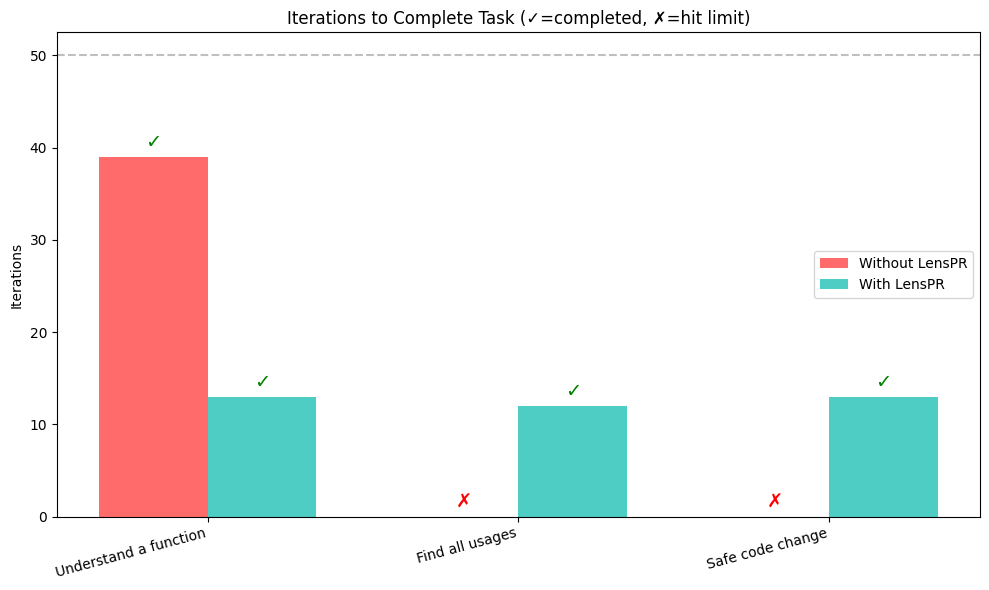

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

tasks = list(TASKS.keys())
task_names = [TASKS[t]['name'] for t in tasks]
x = np.arange(len(tasks))
width = 0.35

without_iters = []
with_iters = []
without_completed = []
with_completed = []

for task_id in tasks:
    wo = results.get(f"{task_id}_without_lenspr")
    w = results.get(f"{task_id}_with_lenspr")
    
    without_iters.append(wo.iterations if wo else 0)
    with_iters.append(w.iterations if w else 0)
    without_completed.append(wo.completed if wo else False)
    with_completed.append(w.completed if w else False)

bars1 = ax.bar(x - width/2, without_iters, width, label='Without LensPR', color='#ff6b6b')
bars2 = ax.bar(x + width/2, with_iters, width, label='With LensPR', color='#4ecdc4')

# Add completion markers
for i, (completed, bar) in enumerate(zip(without_completed, bars1)):
    marker = '✓' if completed else '✗'
    color = 'green' if completed else 'red'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, marker, 
            ha='center', va='bottom', fontsize=14, color=color)

for i, (completed, bar) in enumerate(zip(with_completed, bars2)):
    marker = '✓' if completed else '✗'
    color = 'green' if completed else 'red'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, marker, 
            ha='center', va='bottom', fontsize=14, color=color)

ax.set_ylabel('Iterations')
ax.set_title('Iterations to Complete Task (✓=completed, ✗=hit limit)')
ax.set_xticks(x)
ax.set_xticklabels(task_names, rotation=15, ha='right')
ax.legend()
ax.axhline(y=MAX_ITERATIONS, color='gray', linestyle='--', alpha=0.5, label=f'Max ({MAX_ITERATIONS})')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'chart_iterations.png', dpi=150)
plt.show()

### Chart 2: Total Input Tokens

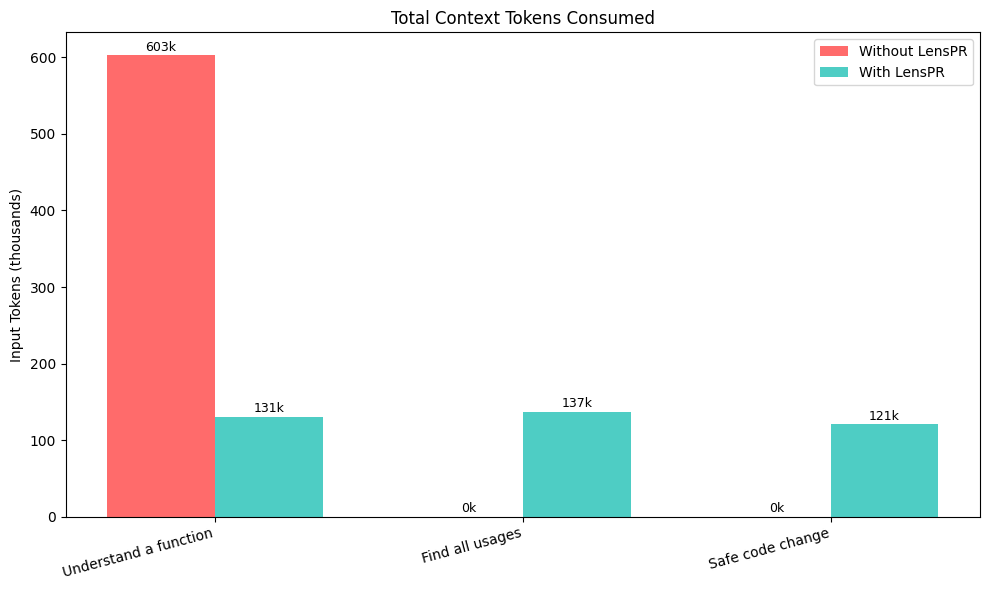

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

without_tokens = [results.get(f"{t}_without_lenspr").total_input_tokens if results.get(f"{t}_without_lenspr") else 0 for t in tasks]
with_tokens = [results.get(f"{t}_with_lenspr").total_input_tokens if results.get(f"{t}_with_lenspr") else 0 for t in tasks]

bars1 = ax.bar(x - width/2, [t/1000 for t in without_tokens], width, label='Without LensPR', color='#ff6b6b')
bars2 = ax.bar(x + width/2, [t/1000 for t in with_tokens], width, label='With LensPR', color='#4ecdc4')

ax.set_ylabel('Input Tokens (thousands)')
ax.set_title('Total Context Tokens Consumed')
ax.set_xticks(x)
ax.set_xticklabels(task_names, rotation=15, ha='right')
ax.legend()

# Add value labels
for bar, val in zip(bars1, without_tokens):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val/1000:.0f}k', 
            ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, with_tokens):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val/1000:.0f}k', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'chart_tokens.png', dpi=150)
plt.show()

### Chart 3: Cumulative Tokens Over Iterations

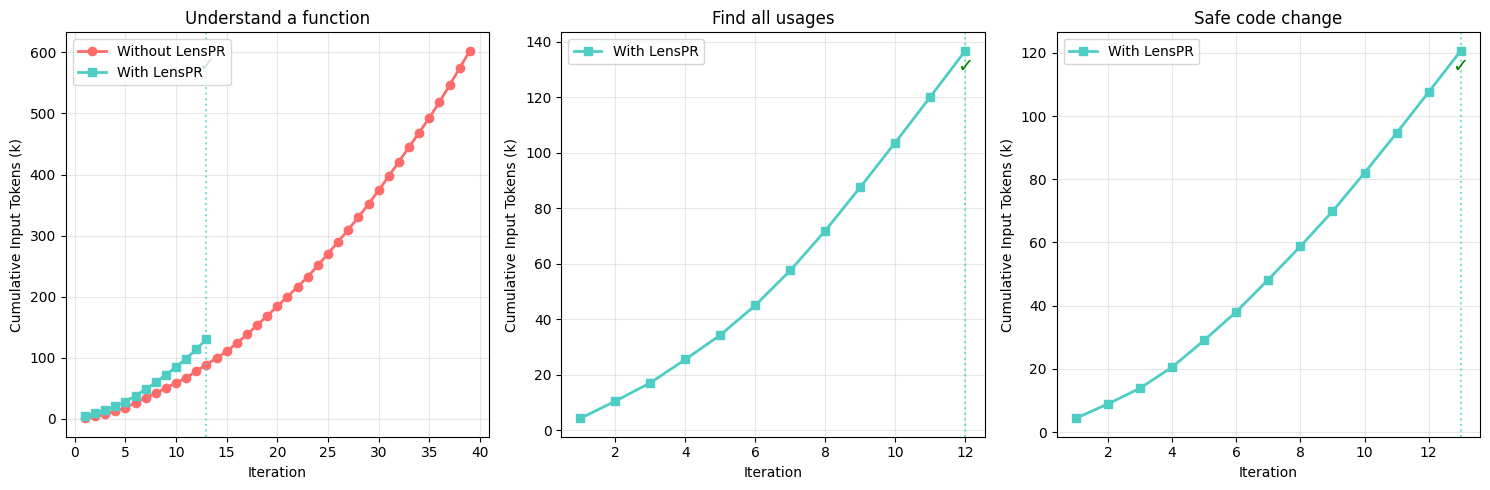

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, task_id in enumerate(tasks):
    ax = axes[idx]
    task_name = TASKS[task_id]['name']
    
    wo = results.get(f"{task_id}_without_lenspr")
    w = results.get(f"{task_id}_with_lenspr")
    
    if wo and wo.tokens_per_iteration:
        iters = [t['iteration'] for t in wo.tokens_per_iteration]
        cumulative = [t['cumulative_input']/1000 for t in wo.tokens_per_iteration]
        ax.plot(iters, cumulative, 'o-', color='#ff6b6b', label='Without LensPR', linewidth=2)
        if not wo.completed:
            ax.axvline(x=wo.iterations, color='#ff6b6b', linestyle='--', alpha=0.5)
    
    if w and w.tokens_per_iteration:
        iters = [t['iteration'] for t in w.tokens_per_iteration]
        cumulative = [t['cumulative_input']/1000 for t in w.tokens_per_iteration]
        ax.plot(iters, cumulative, 's-', color='#4ecdc4', label='With LensPR', linewidth=2)
        if w.completed:
            ax.axvline(x=w.iterations, color='#4ecdc4', linestyle=':', alpha=0.7)
            ax.text(w.iterations, ax.get_ylim()[1]*0.9, '✓', color='green', fontsize=14, ha='center')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cumulative Input Tokens (k)')
    ax.set_title(task_name)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'chart_cumulative.png', dpi=150)
plt.show()

### Chart 4: Tool Usage Breakdown

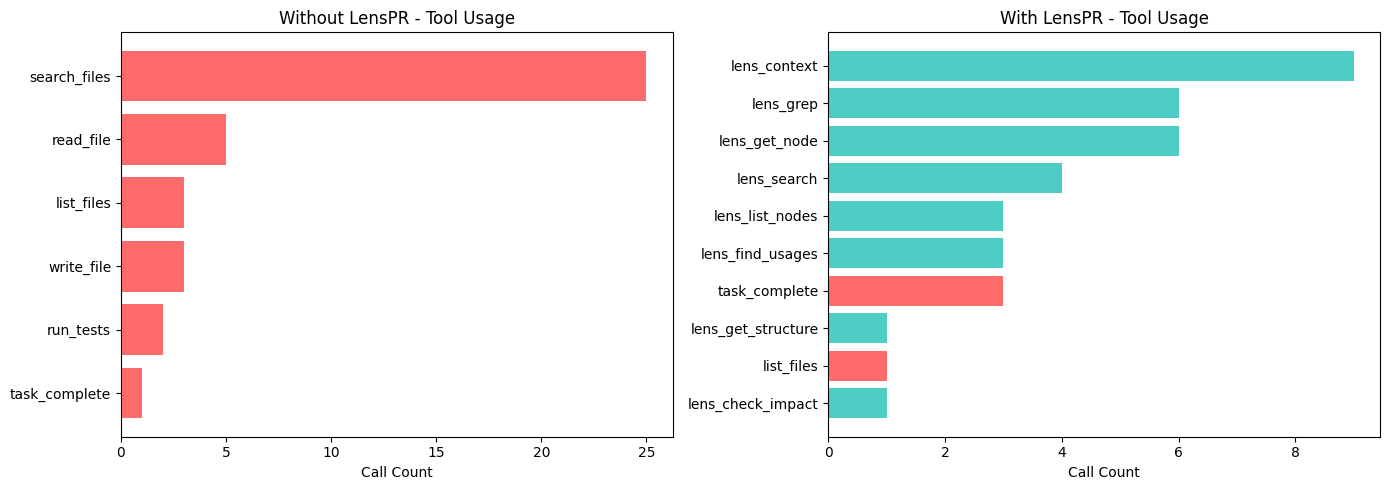

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count tool usage
def count_tools(results_list):
    counts = {}
    for r in results_list:
        if r:
            for tc in r.tool_calls:
                name = tc['name']
                counts[name] = counts.get(name, 0) + 1
    return counts

without_results = [results.get(f"{t}_without_lenspr") for t in tasks]
with_results = [results.get(f"{t}_with_lenspr") for t in tasks]

without_counts = count_tools(without_results)
with_counts = count_tools(with_results)

# Without LensPR
ax = axes[0]
if without_counts:
    tools_sorted = sorted(without_counts.items(), key=lambda x: -x[1])[:10]
    names, counts = zip(*tools_sorted)
    colors = ['#ff6b6b' if not n.startswith('lens_') else '#4ecdc4' for n in names]
    ax.barh(names, counts, color=colors)
    ax.set_xlabel('Call Count')
    ax.set_title('Without LensPR - Tool Usage')
    ax.invert_yaxis()

# With LensPR
ax = axes[1]
if with_counts:
    tools_sorted = sorted(with_counts.items(), key=lambda x: -x[1])[:10]
    names, counts = zip(*tools_sorted)
    colors = ['#4ecdc4' if n.startswith('lens_') else '#ff6b6b' for n in names]
    ax.barh(names, counts, color=colors)
    ax.set_xlabel('Call Count')
    ax.set_title('With LensPR - Tool Usage')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'chart_tools.png', dpi=150)
plt.show()

## Summary Table

In [19]:
def summary_table(results: dict):
    print("\n" + "="*90)
    print("SUMMARY: LensPR Impact on Claude Code Performance (max_iterations=50)")
    print("="*90)
    print()
    
    totals = {"with": {"in": 0, "out": 0, "iter": 0, "tools": 0, "completed": 0},
              "without": {"in": 0, "out": 0, "iter": 0, "tools": 0, "completed": 0}}
    
    print(f"{'Task':<25} {'Mode':<10} {'Input':>10} {'Output':>10} {'Iter':>6} {'Tools':>6} {'Done':>6}")
    print("-" * 90)
    
    for task_id in TASKS.keys():
        for mode in ["without_lenspr", "with_lenspr"]:
            key = f"{task_id}_{mode}"
            if key in results:
                r = results[key]
                mode_short = "WITHOUT" if "without" in mode else "WITH"
                done = "✓" if r.completed else "✗"
                print(f"{TASKS[task_id]['name']:<25} {mode_short:<10} {r.total_input_tokens:>10,} {r.total_output_tokens:>10,} {r.iterations:>6} {r.tool_call_count:>6} {done:>6}")
                
                m = "without" if "without" in mode else "with"
                totals[m]["in"] += r.total_input_tokens
                totals[m]["out"] += r.total_output_tokens
                totals[m]["iter"] += r.iterations
                totals[m]["tools"] += r.tool_call_count
                totals[m]["completed"] += 1 if r.completed else 0
        print()
    
    print("-" * 90)
    print(f"{'TOTAL':<25} {'WITHOUT':<10} {totals['without']['in']:>10,} {totals['without']['out']:>10,} {totals['without']['iter']:>6} {totals['without']['tools']:>6} {totals['without']['completed']}/3")
    print(f"{'TOTAL':<25} {'WITH':<10} {totals['with']['in']:>10,} {totals['with']['out']:>10,} {totals['with']['iter']:>6} {totals['with']['tools']:>6} {totals['with']['completed']}/3")
    
    # Calculate improvements
    print("\n" + "="*90)
    print("IMPROVEMENTS WITH LENSPR")
    print("="*90)
    
    if totals['without']['iter'] > 0:
        iter_savings = (totals['without']['iter'] - totals['with']['iter']) / totals['without']['iter'] * 100
        print(f"📉 Iterations: {totals['without']['iter']} → {totals['with']['iter']} ({iter_savings:+.1f}%)")
    
    if totals['without']['in'] > 0:
        token_diff = (totals['with']['in'] - totals['without']['in']) / totals['without']['in'] * 100
        print(f"📊 Input tokens: {totals['without']['in']:,} → {totals['with']['in']:,} ({token_diff:+.1f}%)")
    
    print(f"✅ Completion: {totals['without']['completed']}/3 → {totals['with']['completed']}/3")

summary_table(results)


SUMMARY: LensPR Impact on Claude Code Performance (max_iterations=50)

Task                      Mode            Input     Output   Iter  Tools   Done
------------------------------------------------------------------------------------------
Understand a function     WITHOUT       602,625      5,311     39     39      ✓
Understand a function     WITH          130,627      2,189     13     13      ✓

Find all usages           WITH          136,721      2,361     12     12      ✓

Safe code change          WITH          120,661      1,880     13     13      ✓

------------------------------------------------------------------------------------------
TOTAL                     WITHOUT       602,625      5,311     39     39 1/3
TOTAL                     WITH          388,009      6,430     38     38 3/3

IMPROVEMENTS WITH LENSPR
📉 Iterations: 39 → 38 (+2.6%)
📊 Input tokens: 602,625 → 388,009 (-35.6%)
✅ Completion: 1/3 → 3/3
